In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchsummary
from torch.autograd import Variable
from copy import deepcopy

In [5]:
num_epochs = 5
batch_size = 64
num_classes = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.ToTensor()

train_data = datasets.MNIST('./data', train=True, download=True, transform=transform);
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True);

val_data = datasets.MNIST('./data', train=False, download=True, transform=transform);
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False);

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_data), 'val': len(val_data)}

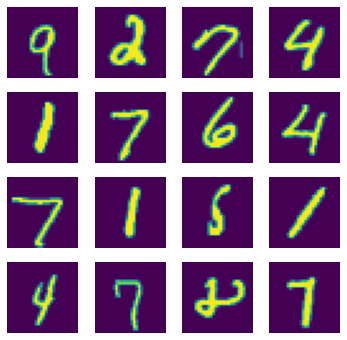

In [6]:
fig = plt.figure(figsize=(6,6))
for i in range(16):
  index = np.random.randint(len(train_data))
  img, label = train_data[index]
  fig.add_subplot(4, 4, i+1)
#  plt.title('label: {}'.format(label))
  plt.axis('off')
  plt.imshow(torch.reshape(img, (28,28)))

###Train autoencoder

In [7]:
def train_autoencoder(model, criterion, optimizer, dataloader):
  model.train()
  loss_history = []
  for epoch in range(num_epochs):
    running_loss = 0
    for inputs, _ in dataloader:
        inputs = inputs.view(inputs.shape[0], -1)
        inputs = Variable(inputs.to(device))
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    loss_history.append(running_loss / len(dataloader.dataset))
    print('epoch [{}/{}], loss:{:.4f}\n'.format(epoch+1, num_epochs, loss.item()))

  return model, loss_history

In [8]:
class Autoencoder(nn.Module):
  def __init__(self, input_size=28*28):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_size, 128),
        nn.ReLU())
#        nn.Linear(64,64),
#        nn.ReLU())
    self.decoder = nn.Sequential(
        nn.Linear(128, input_size),
        nn.Sigmoid())
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x


In [9]:
model = Autoencoder().to(device)
criterion = nn.MSELoss().to(device)

optimiser = optim.Adam(model.parameters(), lr=1e-3)

In [10]:
autoencoder, _ = train_autoencoder(model, criterion, optimiser, train_loader)

epoch [1/5], loss:0.0114

epoch [2/5], loss:0.0063

epoch [3/5], loss:0.0031

epoch [4/5], loss:0.0029

epoch [5/5], loss:0.0024



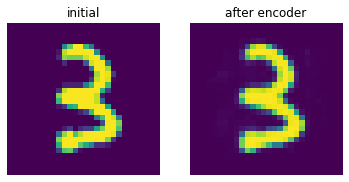

In [13]:
fig = plt.figure(figsize=(6,3))
fig.add_subplot(1, 2, 1)
index = np.random.randint(len(val_data))
img, _ = val_data[index]
plt.title('initial')
plt.axis('off')
plt.imshow(torch.reshape(img, (28,28)));

fig.add_subplot(1, 2, 2)
img = Variable(img).to(device)
img_encoded = autoencoder(img.view(img.shape[0], -1))
img_encoded = torch.reshape(img_encoded, (28, 28))
plt.title('after autoencoder')
plt.axis('off')
plt.imshow(img_encoded.cpu().detach());

###Train classifier

In [17]:
model = nn.Sequential(nn.Linear(10,10),nn.Sigmoid()).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#optimizer = optim.SGD(model.parameters(), lr=1e-3)

num_epochs = 10

In [18]:
def train_classifier(classifier, autoencoder, criterion, optimizer, dataloaders, dataset_sizes):

  for param in autoencoder.parameters():
    param.requires_grad = False

  for epoch in range(num_epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_correct = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.view(inputs.shape[0], -1)
        inputs = Variable(inputs.to(device))
        labels = Variable(labels.to(device))
        optimizer.zero_grad()

        logits = autoencoder.encoder(inputs)
        semantic = logits[:, :10]

        outputs = classifier(semantic)
        _, preds = torch.max(outputs, 1)  
        loss = criterion(outputs, labels)
        if phase == 'train':
            loss.backward()
            optimizer.step()
            
        running_loss += loss.item() * inputs.size(0)
        running_correct += torch.sum(labels == preds.data)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_correct.double() / dataset_sizes[phase]

      print('{} epoch [{}/{}], loss: {:.4f}, acc: {:.4f}'.format(
                phase, epoch+1, num_epochs, epoch_loss, epoch_acc))
    print()
  return classifier

In [19]:
classifier = train_classifier(model, autoencoder, criterion, optimizer, dataloaders, dataset_sizes)

train epoch [1/10], loss: 2.1230, acc: 0.3024
val epoch [1/10], loss: 2.0204, acc: 0.4356

train epoch [2/10], loss: 2.0010, acc: 0.4272
val epoch [2/10], loss: 1.9703, acc: 0.4469

train epoch [3/10], loss: 1.9693, acc: 0.4385
val epoch [3/10], loss: 1.9490, acc: 0.4549

train epoch [4/10], loss: 1.9540, acc: 0.4414
val epoch [4/10], loss: 1.9377, acc: 0.4560

train epoch [5/10], loss: 1.9446, acc: 0.4435
val epoch [5/10], loss: 1.9301, acc: 0.4609

train epoch [6/10], loss: 1.9382, acc: 0.4435
val epoch [6/10], loss: 1.9241, acc: 0.4583

train epoch [7/10], loss: 1.9335, acc: 0.4421
val epoch [7/10], loss: 1.9205, acc: 0.4528

train epoch [8/10], loss: 1.9298, acc: 0.4436
val epoch [8/10], loss: 1.9175, acc: 0.4572

train epoch [9/10], loss: 1.9269, acc: 0.4435
val epoch [9/10], loss: 1.9145, acc: 0.4572

train epoch [10/10], loss: 1.9245, acc: 0.4428
val epoch [10/10], loss: 1.9120, acc: 0.4577



### Attack it

In [68]:
def attack(model, input, target, num_iter, alpha):
  model.eval()
  with torch.set_grad_enabled(True):
    img = deepcopy(input)
    output_targ = model(target)[:, :10]
    best_loss = 10000.
    best_img = deepcopy(img)
    img = Variable(img, requires_grad=True)
    for i in range(num_iter):
      
      output = model(img)[:, :10]
      loss = torch.norm(output - output_targ, p=2)
      loss.backward(retain_graph=True)

      if loss.item() < best_loss:
        best_loss = loss.item()
        best_img = deepcopy(img)
      
      #step
      img.data -= alpha * torch.sign(img.grad.data)

  return best_img, best_loss

4


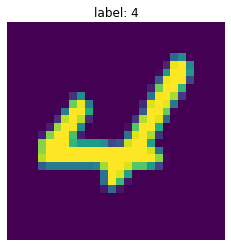

In [43]:
index1 = np.random.randint(len(val_loader.dataset))
img1, label1 = val_loader.dataset[index1]
plt.title('label: {}'.format(label1))
plt.axis('off')
plt.imshow(torch.reshape(img1, (28,28)));

image1 = img1.view(img1.shape[0], -1)
semantic1 = autoencoder.encoder(image1)[:,:10]
output1 = classifier(semantic1)
_, preds = torch.max(output1, 1)
print(preds.item())

7


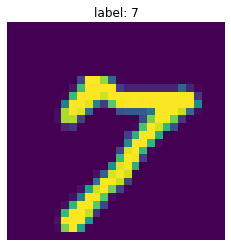

In [42]:
index2 = np.random.randint(len(val_loader.dataset))
img2, label2 = val_loader.dataset[index2]
plt.title('label: {}'.format(label2))
plt.axis('off')
plt.imshow(torch.reshape(img2, (28,28)));

image2 = img2.view(img2.shape[0], -1)
semantic2 = autoencoder.encoder(image2)[:,:10]
output2 = classifier(semantic2)
_, preds = torch.max(output2, 1)
print(preds.item())

In [78]:
adv, _ = attack(autoencoder.encoder, image1, image2, 30, 1./255)

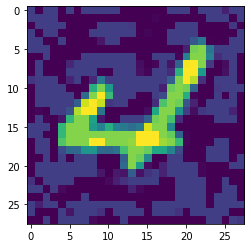

In [79]:
plt.imshow(torch.reshape(adv, (28, 28)).detach());

In [80]:
adv = adv.view(adv.shape[0], -1)
semantic = autoencoder.encoder(adv)[:,:10]
output = classifier(semantic)
_, preds = torch.max(output, 1)
print(preds.item())

7
